# Experiment 8a - Train ANN on fixed number of practiced tasks (200 epochs of practiced tasks)

In [1]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from model import analysis
from importlib import reload
import tools
import pandas as pd
analysis = reload(analysis)
sns.set_style("whitegrid")

In [2]:
datadir = '../../data/model_results/experiment8/'
palette = sns.color_palette("Set2")


#### Sample commands for 3 networks
`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 0 --nepochs 200 --pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 0 --nepochs 200 --rule2pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 0 --nepochs 200 --practice --cuda --verbose --nsimulations 40`

# Load data and format dataframes

In [3]:
simstart = 0
simend = 40

#
df_adam = pd.DataFrame()
#
df_adam_1rule = pd.DataFrame()
#
df_adam_nopretraining = pd.DataFrame()

for i in range(simstart,simend):
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_200epochs_2layers_2rulepretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_200epochs_2layers_pretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_200epochs_2layers_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
    # Include zero-shot dataframes
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_2rulepretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_pretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
df_all = pd.concat([df_adam_nopretraining,
                    df_adam_1rule,
                    df_adam])

# Transform accuracies to out of 100%
df_all.Accuracy = df_all.Accuracy.values * 100.0

##########
# Calculate total number of training samples/trials per simulation
df_all['TotalTrials'] = df_all[['NumPretrainingTrials', 'NumActualTrials']].sum(axis=1)

##########
# Calculate average PS scores
df_all['PS1'] = df_all[['LogicPS1', 'SensoryPS1', 'MotorPS1']].mean(axis=1)
df_all['PS2'] = df_all[['LogicPS2', 'SensoryPS2', 'MotorPS2']].mean(axis=1)
df_all['PSavg'] = df_all[['PS1', 'PS2']].mean(axis=1)


## Accuracy vs. NumPracticedTasks

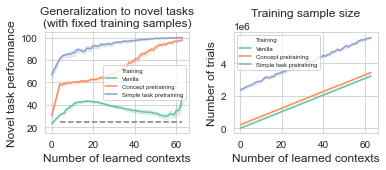

In [4]:
# prac_acc = df.loc[df['Condition']=='Practiced']
# rule2_acc = df.loc[df['Condition']=='2-rule overlap']
# rule1_acc = df.loc[df['Condition']=='1-rule overlap']
plt.figure(figsize=(5.5,2.5))
plt.subplot(1,2,1)
sns.lineplot(x="NumPracticedTasks",y="Accuracy",hue="Training",data=df_all,palette="Set2")
plt.plot(np.arange(4,64),np.repeat(25,len(np.arange(4,64))),'gray',linestyle='--')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Generalization to novel tasks\n(with fixed training samples)', fontsize=12)
plt.xlabel('Number of learned contexts', fontsize=12)
plt.ylabel('Novel task performance', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.ylim([15,105])
plt.legend(fontsize=6)

plt.subplot(1,2,2)
sns.lineplot(x="NumPracticedTasks",y="TotalTrials",hue="Training",data=df_all,palette="Set2")
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Training sample size', fontsize=12,y=1.1)
plt.xlabel('Number of learned contexts', fontsize=12)
plt.ylabel('Number of trials', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.legend(fontsize=6)
plt.tight_layout()
# plt.savefig('Expt8a_FixedEpochs.png',dpi=300)

## PS vs. NumPracticedTasks

1-rule vs. vanilla network PS: t = -0.87 | p = 0.387


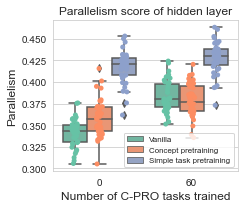

In [6]:
df_ps = pd.concat([df_all.loc[df_all.NumPracticedTasks==0],
                   df_all.loc[df_all.NumPracticedTasks==60]])

plt.figure(figsize=(3.5,3))
ax = sns.boxplot(x="NumPracticedTasks",y="PSavg",hue='Training',palette='Set2',data=df_ps)
sns.stripplot(x="NumPracticedTasks",y="PSavg",hue='Training',palette='Set2',dodge=True,data=df_ps)
plt.title('Parallelism score of hidden layer', fontsize=12)
plt.xlabel('Number of C-PRO tasks trained', fontsize=12)
plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
# plt.ylim([0,.5])
plt.legend()
# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=8)
# plt.ylim([0,.5])


plt.tight_layout()
# plt.savefig('Experiment8a_ModelPS_Average.png', dpi=300)

#### t-test
# 1-rule versus vanilla
tmp=df_ps.loc[df_ps.NumPracticedTasks==60]
tmp_vanilla = tmp.loc[tmp.Training=='Vanilla']
tmp_1rule = tmp.loc[tmp.Training=='Concept pretraining']
t, p = stats.ttest_ind(tmp_1rule.PSavg.values,tmp_vanilla.PSavg.values)
print('1-rule vs. vanilla network PS: t =', round(t,3), '| p =', round(p,3))